# The Inverted Pendulum (or the Cart-Pole System)

In this notebook, we will go through implementing the inverted pendulum system for which we'll train a neural network to learn to control the pendulum state.

A part of this exercise will also show you how to make animations in matplotlib!

In [1]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

import math
import copy

from IPython.display import HTML

import neuralode
import warnings
warnings.simplefilter('ignore', RuntimeWarning)

In [2]:
# For convenience, we define the default tensor device and dtype here
torch.set_default_device('cuda' if torch.cuda.is_available() else 'cpu')
# In neural networks, we prefer 32-bit/16-bit floats, but for precise integration, 64-bit is preferred. On CPUs we'll use float64 as this incurs minimal cost compared to on GPUs where we'll use float32
torch.set_default_dtype(torch.float32)

# Implementing the Cart-Pole System

## The Dynamics

The cart-pole system is a dynamical system comprising of a cart attached to a linear track with one-degree of freedom (the x-axis), and a rigid pole attach to the cart with one-degree of freedom (the rotational axis). While the equations can be complicated due to the interaction between the cart and the pole, the system itself is easy to imagine. Unlike the previous systems, we will not derive the equations of the system in this notebook as they require an understanding of force-balance equations, and instead quote them below[\[1\]](##references):

$$
\theta^{(2)}=
\frac{g\sin\theta + \cos\theta\left\{\frac{-F_p + d_N\cos\theta}{m_T} + g d_N\right\}-\frac{\mu_p\theta^{(1)}}{m_p l}}{l\left\{\frac{4}{3}-\frac{m_p\cos\theta}{m_T}\left[\cos\theta - d_N\right]\right\}}
$$
and
$$ x^{(2)} =
\frac{F_p - m_p l \theta^{(2)}\cos\theta - N_c d_N}{m_T}
$$
where 

$$
m_T = m_c + m_p
$$

$$
N_c=m_T g-m_p l \left(\theta^{(2)}\sin\theta +\left[\theta^{(1)}\right]^2\cos\theta\right)
$$

$$
d_N = \mu_c\mathrm{sgn}\left(N_c x^{(1)}\right)
$$

$$
F_p = F + m_p l \left[\theta^{(1)}\right]^2\sin\theta
$$
If we neglect friction (i.e. $\mu_p = \mu_c = 0$) then this simplifies to:

$$
\theta^{(2)}=
\frac{g\sin\theta + \cos\theta\frac{-F_p}{m_T}}{l\left\{\frac{4}{3}-\frac{m_p\cos^2\theta}{m_T}\right\}}
$$
and
$$
x^{(2)} = \frac{F_p - m_p l \theta^{(2)}\cos\theta}{m_T}
$$

Using the same transformation as before, we can write this as a first-order Ordinary Differential Equation by introducing $\omega=\theta^{(1)}$ and $v = x^{(1)}$ as variables and denoting the state $\vec{x}=\left[\theta, \omega, x, v\right]$, we get the dynamical equations
$$
\vec{x}^{(1)}=
\begin{bmatrix}
\omega \\
\frac{g\sin\theta + \cos\theta\left\{\frac{-F_p + d_N\cos\theta}{m_T} + g d_N\right\}-\frac{\mu_p\theta^{(1)}}{m_p l}}{l\left\{\frac{4}{3}-\frac{m_p\cos\theta}{m_T}\left[\cos\theta - d_N\right]\right\}} \\
v \\
\frac{F_p - m_p l \theta^{(2)}\cos\theta - N_c d_N}{m_T}
\end{bmatrix}
$$.

You'll note that the right-hand side of the equation depends on $\theta^{(2)}$ through $N_c$ which is also on the left-hand side of our equation. One way to solve this would be to use a non-linear root-finding algorithm to find the exact value of $\theta^{(2)}$ that satisfies this equation, but this would be computationally expensive. If you look closely, $N_c$ is the normal force applied by the track on the cart and for $\theta^{(2)}$ we only use its sign to determine the acceleration of the pole. In most cases, because the cart is attached to the track and weighed down, $N_c$ will be positive so we can assume that it is positive and compute $\theta^{(2)}$ accordingly. Once we've computed $\theta^{(2)}$, we can check that $N_c$ is still positive. If it isn't, we can recompute $\theta^{(2)}$. Because in most cases it will be positive, this incurs minimal computational cost in comparison to using a root-finding scheme.

The implementation itself can be found in `neuralode.dynamics.inverted_pendulum`.

In [3]:
### The System Parameters
mass_cart   = torch.tensor(1.0)  # kg
mass_pole   = torch.tensor(0.1)  # kg
length_pole = torch.tensor(1.0)  # m
gravity     = torch.tensor(9.81) # m/s^2
friction_cart = torch.tensor(0.0)
friction_pole = torch.tensor(0.0)

In [4]:
initial_state = torch.tensor([0.0,-1.0,0.0,0.1])

initial_time = torch.tensor(0.0)
final_time   = torch.tensor(5.0)

initial_timestep = torch.tensor(1e-4)

current_integrator = neuralode.integrators.AdaptiveRKV76Integrator

atol = rtol = 0.01*torch.tensor(torch.finfo(initial_state.dtype).eps**0.5)
common_integrator_parameters = [mass_cart, mass_pole, length_pole, gravity, friction_cart, friction_pole]

In [5]:
final_state, _, pendulum_states, pendulum_times, estimated_errors = current_integrator.apply(neuralode.dynamics.inverted_pendulum, initial_state, initial_time, final_time, initial_timestep, {'atol': atol, 'rtol': rtol}, torch.tensor(0.0), *common_integrator_parameters)

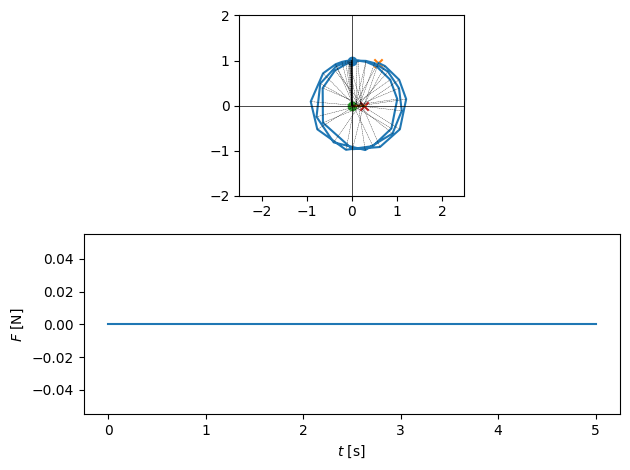

In [6]:
pendulum_x = torch.sin(pendulum_states[...,0]) * length_pole + pendulum_states[...,2]
pendulum_y = torch.cos(pendulum_states[...,0]) * length_pole

cart_x, cart_y = pendulum_states[...,2], torch.zeros_like(pendulum_states[...,2])

neuralode.plot.inverted_pendulum.plot_pendulum(pendulum_x, pendulum_y, cart_x, cart_y, pendulum_times, torch.zeros_like(pendulum_times))
HTML(neuralode.plot.inverted_pendulum.animate_pendulum(pendulum_x, pendulum_y, cart_x, cart_y, pendulum_times, frame_time=1000/60))

# Training a Network

## The Model
First we define the model. We've left the definition in the module if you'd like to look at the implementation, but this is a simple Multi-Layer Perceptron (MLP) model with a default of 6 layers (4 hidden, 1 input, 1 output) using a non-linear CELU activation function. Unlike many other MLPs, we've opted to use CELU activations due to two desirable properties that assists in the training of the network:

1. CELU is $C^1$-continuous (the $1^{st}$ derivative is continuous everywhere)
2. CELU only saturates and dies off when the input is highly negative
    
The first property is desirable because, during the adjoint integration, we are integrating the gradient of the network and discontinuities in the activation function naturally lead to jumps in the adjoint that are difficult to integrate over using explicit integration techniques.
The second property is desirable because our inputs have large magnitudes and have periodic properties, and while we could use normalisation, we'd be removing the periodicity. Instead, sinusoids allow the network to learn periodic control representations that are well suited for a dynamical system such as this.

We have also restricted the maximum force applied by the network to $20\mathrm{N}$ as any real controller would be limited in the amount of force it can apply.

In [7]:
torch.random.manual_seed(1)
random.seed(1)
np.random.seed(1)

model_path = None
model_arguments = dict(max_force=20.0, num_hidden_layers=4, num_hidden_neurons=128)
if model_path is not None:
    model_arguments, model_parameters = torch.load(model_path, map_device=torch.get_default_device)
cart_pole_net = neuralode.models.inverted_pendulum.CartPoleNet(**model_arguments)
if model_path is not None:
    cart_pole_net.load_state_dict(model_parameters)
else:
    cart_pole_net.apply(neuralode.models.util.init_weights)

jitted_dynamics = torch.jit.script(neuralode.dynamics.inverted_pendulum)

def functional_controller(state, time, controller, *nn_parameters):
    return torch.func.functional_call(controller, {k: p for (k, _), p in zip(controller.named_parameters(), nn_parameters)}, (state, time))

def nn_controlled_pendulum(state, time, controller, mc, mp, length, g, mu_c, mu_p, *nn_parameters):
    force = functional_controller(state, time, controller, *nn_parameters)[...,0]
    return jitted_dynamics(state, time, force, mc, mp, length, g, mu_c, mu_p)

## The Dataset
We want our network to learn how to balance the pole over the cart and thus we generate a dataset of nearly balanced poles (within $22.5^\mathrm{o}$ of the vertical position) in various angular velocity, cart position and cart velocity configurations for the network to learn from.

We also add examples, equal to $3.125\%$ of our nearly balanced examples, for which the pole is hanging below the cart so that the network can learn to swing the pole up and over the cart before balancing it.

In [8]:
# As the goal is balancing the pole on top of the cart, we generate initial states where the pole
# is near vertical and moving with some random rotational velocity. This way, the neural network observes
# multiple states near the vertical state where it needs to learn to counter-balance it.
torch.random.manual_seed(2)
num_examples = 256
state_min = torch.tensor([-0.125*torch.pi, -1.0*torch.pi, -10.0, -1.0])
state_max = torch.tensor([ 0.125*torch.pi,  1.0*torch.pi,  10.0,  1.0])
state_dataset = torch.rand(num_examples, *state_max.shape) * (state_max - state_min)[None] + state_min[None]

frac_below = 0.25
if frac_below > 0.0:
    state_min = torch.tensor([-0.5*torch.pi+torch.pi, -1.0*torch.pi, 0.0, 0.0])
    state_max = torch.tensor([ 0.5*torch.pi+torch.pi,  1.0*torch.pi, 0.0, 0.0])
    state_dataset = torch.cat([
        state_dataset, 
        torch.rand(math.ceil(num_examples*frac_below), *state_max.shape) * (state_max - state_min)[None] + state_min[None]
    ], dim=0)

## Loss Function

Ideally the network balances the pole above the cart and this is equivalent to having the pole angle equal zero at all times. To that end, we use an loss of the angular deviation from zero and integrate it alongside the dynamics. This gives us a measure of the angular deviation over time and is a quantity that we would like to minimise.

In [9]:
# As our network needs to minimize the angle across all timesteps,
# we can integrate our loss function alongside the system and then minimize its value at the end.
# While we'd like to minimize all the parameters, we're more interested in the
# pole angle and velocity so we can use weighting to reduce the weight of the other parameters
loss_weights = torch.tensor([2.0, 1.0, 1.0, 1.0])
# Additionally, we add a small force regularisation term to force the network to be sparing with
# its controls and avoid spurious outputs.
def loss_func(x0, t0, controller, *nn_parameters):
    force = functional_controller(x0, t0, controller, *nn_parameters)
    return (loss_weights*x0[...,:4]).square().sum(dim=-1, keepdim=True).sqrt() + 0.001*force.square()

# We append one more state variable that will track our loss.
# Initially it is set to zero as our initial state is
# outside the control of our neural network
state_dataset = torch.cat([
    state_dataset[...,:initial_state.shape[0]],
    torch.zeros_like(state_dataset[...,:1]),
], dim=-1)


def loss_augmented_rhs(x0, t, *nn_parameters):
    return torch.cat([
        nn_controlled_pendulum(x0[...,:4], t, cart_pole_net, *nn_parameters),
        loss_func(x0[...,:4], t, cart_pole_net, *nn_parameters[6:])
    ], dim=-1)

training_integrator_kwargs = {
    'atol': atol,
    'rtol': rtol,
    # Set the adjoint integration tolerances higher as we don't need the gradients to be exact
    'backward_atol': atol,
    'backward_rtol': rtol,
    # Clip the adjoint gradients of the network parameters as these may vary erratically/unstably during the adjoint integration
    'gradient_clipping': torch.tensor(1.0)
}
testing_integrator_kwargs = {
    'atol': atol,
    'rtol': rtol
}

def batched_integrator(x0, integration_duration):
    return current_integrator.apply(loss_augmented_rhs, x0, initial_time, initial_time+integration_duration, initial_timestep, training_integrator_kwargs, *common_integrator_parameters, *cart_pole_net.parameters())

## Training Configuration
We select a batch size of 32 and train for 256 epochs. Unlike our previous networks, the learning rate is set very low as a higher learning rate leads to divergence.

The closure function we have accepts a variable integration duration and thus we have set it so that the returned error is invariant to this. Thus the loss function we're minimising is the maximum deviation of the final state and the rate of the integrated error (as opposed to the integrated error itself).

In [10]:
batch_size = 32
number_of_epochs = 32
number_of_batches = math.ceil(state_dataset.shape[0] / batch_size)
total_steps = number_of_batches * number_of_epochs

optimiser = torch.optim.AdamW(cart_pole_net.parameters(), lr=4e-5, weight_decay=1e-3)

def pendulum_closure(minibatch, integration_duration):
    optimiser.zero_grad()
    
    states = minibatch['states']
    
    final_state, *_ = batched_integrator(states, integration_duration)

    # The error is simply the integrated error over the whole trajectory
    ## The integrated error is divided by the integration duration to give a time invariant error
    error = final_state[...,-1].mean()/integration_duration
    ## Also minimise the final cart position, ideally it will be at the origin at the end of the integration interval
    error = error + final_state[...,:4].abs().sum(dim=-1).mean()
    
    if error.requires_grad:
        error.backward()
    return error

## Training the Network Incrementally

While we could have the network tackle the full problem where it tries to balance the pole over many seconds, this is a very difficult problem.
Instead, we train the network on a set of random states to minimise the error over $0.5$ seconds with a learning rate that initially ramps up quickly and then decays back down. The goal of a ramping learning rate is to escape any local minima the network may get stuck in, in the initial stages of learning.

If the network is able to train successfully over $0.5$ seconds, then, given that any time interval can be split into $0.5$ second increments, our network should still be able to function over a longer period of time.

In [11]:
training_step = []
training_error = []

best_error = torch.inf
best_params = copy.deepcopy(cart_pole_net.state_dict())

cart_pole_net.train()

integration_time = torch.tensor(0.5)
no_improvement = 0
peak_lr = None

for step in range(1, number_of_epochs+1):
    epoch_error = 0.0
    shuffled_indices = torch.randperm(state_dataset.shape[0])
    for batch_idx in range(0, state_dataset.shape[0], batch_size):
        batch_dict = {
            'states': state_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
        }
        try:
            step_error = optimiser.step(lambda: pendulum_closure(batch_dict, integration_time))
        except RuntimeError as e:
            print(e)
            print("This is likely due to the integrator not converging, will reset network and reduce learning rate")
            optimiser.param_groups[0]['lr'] *= 0.25
            cart_pole_net.load_state_dict(best_params)
            continue
        if any(torch.any(~torch.isfinite(i)) for i in cart_pole_net.parameters()) or any(torch.any(~torch.isfinite(i.grad)) for i in cart_pole_net.parameters() if i.requires_grad):
            raise ValueError("Encountered non-finite parameters/parameters gradients")
        epoch_error = epoch_error + step_error.item()*batch_dict['states'].shape[0]
        print(f"[{step}/{number_of_epochs} - {optimiser.param_groups[0]['lr']:.4e} - horizon: {integration_time:.5f}]/[{batch_idx}/{state_dataset.shape[0]}] Batch Error: {step_error:.6f} / Running Epoch Error: {epoch_error/(batch_idx+batch_size):.6f}", end='\r')
        if step < 8:
            optimiser.param_groups[0]['lr'] *= 2.0**(1/number_of_batches)
        elif step > 16:
            if peak_lr is None:
                peak_lr = optimiser.param_groups[0]['lr']
            optimiser.param_groups[0]['lr'] *= (1e-7/peak_lr)**(1/(number_of_batches*(number_of_epochs - 8)))
    epoch_error = epoch_error/state_dataset.shape[0]
    if step == number_of_epochs - 4:
        optimiser.param_groups[0]['lr'] = 1e-5
    training_step.append(step)
    training_error.append(epoch_error)
    print(" "*192, end="\r")
    print(f"[{step}/{number_of_epochs} - {optimiser.param_groups[0]['lr']:.4e} - horizon: {integration_time:.5f}] Epoch Error: {epoch_error:.6f}")
    if epoch_error < best_error*0.9999:
        # if best_error < torch.inf:
        #     integration_time = (integration_time*(best_error/epoch_error)).clamp(max=1.0)
        best_error = epoch_error
        best_params = copy.deepcopy(cart_pole_net.state_dict())
        no_improvement = 0
    else:
        no_improvement += 1
    if no_improvement == 2:
        optimiser.param_groups[0]['lr'] *= 0.25
        cart_pole_net.load_state_dict(best_params)
    if optimiser.param_groups[0]['lr'] <= 1e-7:
        break
    torch.cuda.empty_cache()

[1/32 - 8.0000e-05 - horizon: 0.50000] Epoch Error: 16.809307                                                                                                                                   
[2/32 - 1.6000e-04 - horizon: 0.50000] Epoch Error: 16.630486                                                                                                                                   
[3/32 - 3.2000e-04 - horizon: 0.50000] Epoch Error: 16.399066                                                                                                                                   
[4/32 - 6.4000e-04 - horizon: 0.50000] Epoch Error: 16.164124                                                                                                                                   
[5/32 - 1.2800e-03 - horizon: 0.50000] Epoch Error: 15.931533                                                                                                                                   
[6/32 - 2.5600e-03 - horizon: 0.500

## Results

In the loss graph, we can see that the loss function is successfully decreased over the duration of the training.

Text(0.5, 0, 'Epoch')

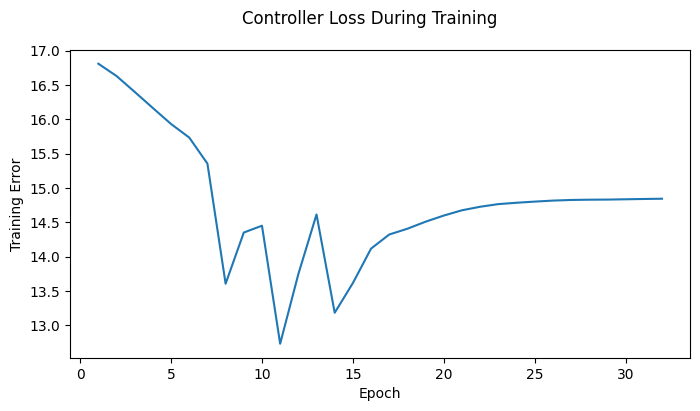

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
fig.suptitle("Controller Loss During Training")
ax.plot(training_step, training_error)
ax.set_ylabel("Training Error")
ax.set_xlabel("Epoch")

Furthermore, looking at the animated plots below, we can see that the network successfully learns to balance an upturned pole over $5$s despite only being trained over a period of $0.5$s. While the network hasn't truly minimised the error in that the cart is offset from the origin (and leaving!), the pole is stable above the cart which is the primary goal of the training.

In [13]:
def test_controller(test_state, test_duration, controller, hide_static_plot=False):
    final_state, _, controlled_pendulum_states, controlled_pendulum_times, errors_achieved = current_integrator.apply(nn_controlled_pendulum, test_state, initial_time, initial_time+test_duration, initial_timestep, testing_integrator_kwargs, controller, *common_integrator_parameters)
    cart_x = controlled_pendulum_states[...,2]
    cart_y = torch.zeros_like(cart_x)
    
    pendulum_x = torch.sin(controlled_pendulum_states[...,0]) * length_pole + cart_x
    pendulum_y = torch.cos(controlled_pendulum_states[...,0]) * length_pole
    
    with torch.no_grad():
        controller_force = controller(controlled_pendulum_states, controlled_pendulum_times)[...,0]
    if not hide_static_plot:
        neuralode.plot.inverted_pendulum.plot_pendulum(pendulum_x, pendulum_y, cart_x, cart_y, controlled_pendulum_times, controller_force)
    return HTML(neuralode.plot.inverted_pendulum.animate_pendulum(pendulum_x, pendulum_y, cart_x, cart_y, controlled_pendulum_times, forces=controller_force, frame_time=1000/60))

In [14]:
cart_pole_net.eval()
cart_pole_net.load_state_dict(best_params)

test_integration_time = 5.0

display(test_controller(initial_state, test_integration_time, cart_pole_net, hide_static_plot=True))
display(test_controller(state_dataset[0,...,:-1], test_integration_time, cart_pole_net, hide_static_plot=True))
display(test_controller(state_dataset[1,...,:-1], test_integration_time, cart_pole_net, hide_static_plot=True))
display(test_controller(state_dataset[2,...,:-1], test_integration_time, cart_pole_net, hide_static_plot=True))
display(test_controller(state_dataset[-1,...,:-1], test_integration_time, cart_pole_net, hide_static_plot=True))
display(test_controller(state_dataset[-2,...,:-1], test_integration_time, cart_pole_net, hide_static_plot=True))
display(test_controller(state_dataset[-3,...,:-1], test_integration_time, cart_pole_net, hide_static_plot=True))

In [15]:
# We can save the network model inside a tuple such that it can be loaded at a later point
torch.save((model_arguments, best_params), "trained-inverted-pendulum.pt")

## Post-Training Notes

That training, on my computer, took $12.5$ hours to run, and there are several files in the "notebooks/artifacts" which are trained models that are all from different runs with the same seed. As can be seen, they result in slightly different networks each time (GPU training is non-deterministic as is CPU training with multiple threads!).

From this, we can see that the network learns how to balance the pole vertically, but struggles to learn how to flip the pole up and over the cart when it's hanging below although we see in some cases that it has learned to swing it back up when it's fallen from the vertical position. Furthermore, the controller starts leaving the origin in almost every case despite being explicitly trained to stay at the origin. This is one of the difficulties of adjoint-based methods, where, unlike reinforcement learning which explicitly controls exploitation vs exploration, we're limited to the signal provided by the gradients of the dynamics which can suffer from local minima and instability.

Some solutions could be to include a different position encoding where rather than passing the position and velocity directly to the network we use a sum of sinusoids to encode the information, enforcing some kind of translational invariance. The downside of these methods is that the loss function is not translationally invariant and so these encodings would be at odds with the objective of the training. Another alternative is to cap the magnitude of the distance, $x$ passed to the network so that it remains within the domain of the dataset it was trained on.

Neural networks are fickle to train, the above parameters that led to a successfully trained network took quite a lot of guided trial-and-error, especially in terms of picking an appropriate learning rate and learning schedule, and dataset sizes. It is absolutely worth exploring these parameters to see their effects on the training, and try to find ways to improve the convergence of the network. Some ideas to experiment with are weighting the integrated error term differently, dynamically adjusting the weight of the integrated error term based on the integration duration, or changing its form from $\int_{t_0}^{t_1}\omega\mathrm{d}t$ to $\int_{t_0}^{t_1}\omega t\mathrm{d}t$ so that deviations from the target angle of $\omega=0$ at later times have greater weight than earlier times.

# References
\[1\]: https://coneural.org/florian/papers/05_cart_pole.pdf